In [1]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
import numpy as np

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

In [ ]:
space  = [Integer(1, 10, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)
    
    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, acq_func="LCB", n_calls=50, verbose=True, kappa=4.)

In [ ]:
import optuna

# 1. Define an objective function to be maximized.
def objective_optuna(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e0, log=True)
    max_features =  trial.suggest_int("max_features", 1, n_features, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100, log=True)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100, log=True)
    
    reg = GradientBoostingRegressor(n_estimators=50,
                                    max_depth=max_depth,
                                    max_features=max_features,
                                    learning_rate=learning_rate,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf)
    
    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

# 3. Create a study object and optimize the objective function.
study = optuna.create_study()
study.optimize(objective_optuna, n_trials=100)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

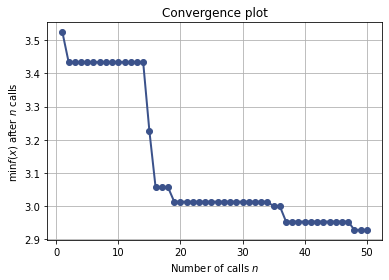

In [13]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [14]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))


Best parameters:
- max_depth=6
- learning_rate=0.104247
- max_features=8
- min_samples_split=43
- min_samples_leaf=1
